In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from sklearn.decomposition import PCA
import json

# Adjustable variables
min_cluster_size = 5  # Default: 5, Recommended range: 1-20
min_samples = 1  # Default: 1, Recommended range: 1-10
cluster_selection_epsilon = 0.0  # Default: 0.0, Recommended range: 0.0-1.0
metric = 'euclidean'  # Default: 'euclidean', Options: 'euclidean', 'cosine', 'manhattan'

with open('embedded_bookmarks.json') as file:
    bookmarks = json.load(file)

# Extract embeddings from the bookmarks data
embeddings = [bookmark["embedding"] for bookmark in bookmarks]

# PCA dim reduction
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(embeddings)

# Apply HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples,
                            cluster_selection_epsilon=cluster_selection_epsilon, metric=metric,
                            gen_min_span_tree=True)
clusterer.fit(reduced_features)

# Build the cluster hierarchy
cluster_hierarchy = {}
for _, row in clusterer.condensed_tree_.to_pandas().iterrows():
    child = row['child']
    parent = row['parent']
    if parent not in cluster_hierarchy:
        cluster_hierarchy[parent] = {'children': []}
    if child not in cluster_hierarchy:
        cluster_hierarchy[child] = {'children': []}
    cluster_hierarchy[parent]['children'].append(child)

# Find the root cluster
root_cluster = None
for cluster_id in cluster_hierarchy:
    if cluster_id not in [child for parent in cluster_hierarchy for child in cluster_hierarchy[parent]['children']]:
        root_cluster = cluster_id
        break

# Map cluster IDs to their corresponding bookmarks
cluster_bookmarks = {}
for i, cluster_id in enumerate(clusterer.labels_):
    if cluster_id not in cluster_bookmarks:
        cluster_bookmarks[cluster_id] = []
    cluster_bookmarks[cluster_id].append(bookmarks[i])

# Generate prompts for each cluster considering the hierarchy
def generate_prompts(cluster_id, indent=""):
    prompts = []
    folder_name = f"Folder {cluster_id}"
    if cluster_id in cluster_bookmarks:
        bookmarks = cluster_bookmarks[cluster_id]
        bookmark_titles = [bookmark["title"] for bookmark in bookmarks]
        bookmark_titles_str = "\n".join([f"{indent}  - {title}" for title in bookmark_titles])
        prompt = f"{indent}Folder: {folder_name}\n{bookmark_titles_str}"
        prompts.append(prompt)
   
    if cluster_id in cluster_hierarchy:
        children = cluster_hierarchy[cluster_id]["children"]
        for child_id in children:
            child_prompts = generate_prompts(child_id, indent + "  ")
            prompts.extend(child_prompts)
   
    return prompts

prompts = generate_prompts(root_cluster)

# Print the generated prompts
for prompt in prompts:
    print(prompt)
    print()

      Folder: Folder 28.0
        - Flexfit - V-Flex Twill Cap - CVF038 | Custom Image Wear | Phelps
        - Latent Space | swyx & Alessio | Substack
        - [2109.02124] The Koha Code: A Biological Theory of Memory
        - links and such – books are life
        - Online Banking Log In
        - When you become a smart trolls personal enemy - Imgur
        - Fastly error: unknown domain uk.businessinsider.com
        - Sanford Careers - Unified Communications Technician - IT - Sioux Falls in Sioux Falls, South Dakota, United States
        - Features | Cursor - The AI-first Code Editor
        - Untitled Bookmark
        - Untitled Bookmark

          Folder: Folder 26.0
            - Customize Firefox
            - Dark Seas Division
            - 3D Gaussian Splatting for Real-Time Radiance Field Rendering
            - Whisper JAX - a Hugging Face Space by sanchit-gandhi
            - Untitled Bookmark

          Folder: Folder 35.0
            - 404 Not Found
            - M

/home/tim/miniconda3/lib/python3.12/site-packages/hdbscan/plots.py:837: RuntimeWarning: divide by zero encountered in divide
  line_width = edge_linewidth * (np.log(self._mst.T[2].max() / self._mst.T[2]) + 1.0)
/home/tim/miniconda3/lib/python3.12/site-packages/matplotlib/lines.py:78: RuntimeWarning: invalid value encountered in scalar multiply
  scaled_offset = offset * lw


<Axes: >

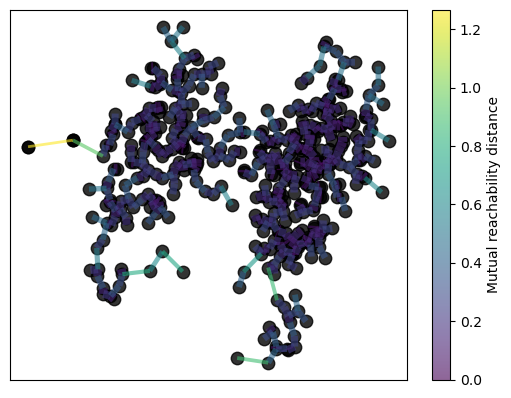

In [10]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', 
                                      edge_alpha=0.6, 
                                      node_size=80, 
                                      edge_linewidth=2)

<Axes: ylabel='distance'>

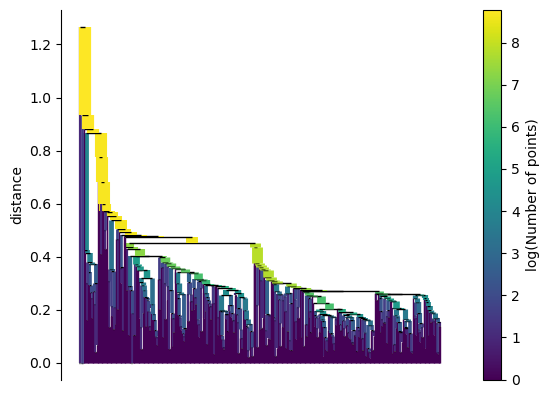

In [11]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

<Axes: ylabel='$\\lambda$ value'>

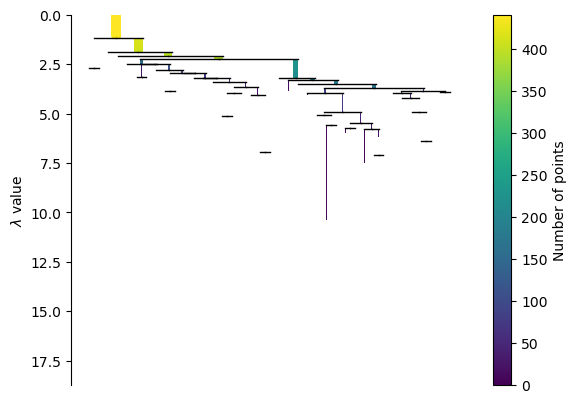

In [12]:
clusterer.condensed_tree_.plot()

<Axes: ylabel='$\\lambda$ value'>

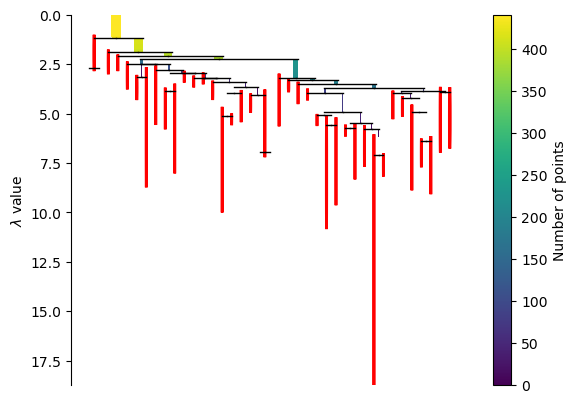

In [13]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [14]:
import numpy as np
from sklearn.decomposition import PCA
import hdbscan
import json

def cluster_bookmarks(bookmark_data):
    # Parse the JSON input if it's a string
    if isinstance(bookmark_data, str):
        bookmark_data = json.loads(bookmark_data)

    print("Received bookmark data:", bookmark_data)
    
    # Extract embeddings from the bookmark data
    embeddings = np.array([bookmark["embedding"] for bookmark in bookmark_data])
    print("Extracted embeddings:", embeddings)
    
    # Validate that there is at least one non-empty embedding array
    if embeddings.size == 0:
        raise ValueError("Embeddings are empty. Cannot perform clustering.")
    
    # Reduce the dimensionality of the embeddings using PCA
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    
    # Create an instance of the HDBSCAN clusterer with the specified hyperparameters
    clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=2,
                                cluster_selection_epsilon=0.2, metric='euclidean',
                                gen_min_span_tree=True)
    
    # Fit the clusterer to the reduced embeddings
    clusterer.fit(reduced_embeddings)
    
    # Build the cluster hierarchy from the condensed tree
    cluster_hierarchy = {}
    for _, row in clusterer.condensed_tree_.to_pandas().iterrows():
        child = row['child']
        parent = row['parent']
        if parent not in cluster_hierarchy:
            cluster_hierarchy[parent] = {'children': []}
        if child not in cluster_hierarchy:
            cluster_hierarchy[child] = {'children': []}
        cluster_hierarchy[parent]['children'].append(child)
    
    # Find the root cluster
    root_cluster = None
    for cluster_id in cluster_hierarchy:
        if cluster_id not in [child for parent in cluster_hierarchy for child in cluster_hierarchy[parent]['children']]:
            root_cluster = cluster_id
            break
    
    # Assign bookmarks to their respective clusters
    cluster_bookmarks = {}
    for i, cluster_id in enumerate(clusterer.labels_):
        if cluster_id not in cluster_bookmarks:
            cluster_bookmarks[cluster_id] = []
        cluster_bookmarks[cluster_id].append(bookmark_data[i])
    
    # Recursive function to generate the folder structure
    def generate_folder_structure(cluster_id, depth=0):
        folder = {}
        folder["name"] = f"Folder {cluster_id}"
        folder["type"] = "folder"
        folder["children"] = [{"name": bookmark["title"], "type": "bookmark", "url": bookmark["url"]} for bookmark in cluster_bookmarks.get(cluster_id, [])]
        for child_id in cluster_hierarchy.get(cluster_id, {}).get('children', []):
            child_folder = generate_folder_structure(child_id, depth + 1)
            if child_folder:
                folder["children"].append(child_folder)
        if folder["children"]:
            return folder
        else:
            return None
    
    # Generate the root folder structure
    root_folder = {
        "name": "Root",
        "type": "folder",
        "children": [generate_folder_structure(root_cluster)]
    } 
    
    # Return the folder structure as a JSON string
    return json.dumps(root_folder, indent=2)

clusteredBookmarks = cluster_bookmarks(bookmarks)

Received bookmark data: [{'title': 'Get Help', 'url': 'https://support.mozilla.org/products/firefox', 'id': '2PG66FeCWYiW', 'tags': ['firefox', 'support', 'web browser', 'Mozilla', 'help', 'product'], 'embedding': [-0.1558075, -0.33465806, 0.017900277, 0.27406368, 0.05647812, 0.6857117, -0.16716309, -0.1040699, 0.4583413, 0.25937232, -0.9108521, -0.5957581, -0.063025296, -0.06853962, -0.3276245, 0.68464357, 0.14425048, -0.027795125, -0.07983551, 0.32757035, 0.18704167, 0.26714993, -0.9052063, 0.4700226, 0.29240793, 1.5100143, 0.68108827, 0.391951, 1.0529724, 0.30730438, -0.032794952, -0.61157227, -0.7792603, 0.30548555, -0.47743988, -0.40293273, 0.12566987, -0.5043305, -0.5742737, 0.72265166, -0.5175613, 0.41095886, -0.614093, 1.3512452, -0.36223754, 0.3574997, -0.124060825, 0.13559875, -0.26058465, -0.39976197, -0.2735443, -0.707431, 0.12910728, -1.7274414, 0.3836792, 0.46777496, 0.75028074, 0.0491848, -0.5454544, -0.7272949, -0.35196704, 0.5566788, -0.34047395, 0.67559206, 0.49955645

In [15]:
# Convert the clustered_bookmarks from a JSON string to a Python dictionary
clustered_bookmarks = json.loads(clusteredBookmarks)

# Call the visualize_clustered_bookmarks function with the updated clustered_bookmarks variable
visualize_clustered_bookmarks(clustered_bookmarks)

Folder: Root
  Folder: Folder 440.0
    Folder: Folder 442.0
      Folder: Folder 444.0
        Folder: Folder 450.0
          Folder: Folder 452.0
            Folder: Folder 28.0
              Bookmark: Dakota State University Team Site - Home (https://dakotastateuniversity.sharepoint.com/SitePages/Home.aspx)
              Bookmark: SRCA-REU - Research Projects (https://sites.google.com/ncsu.edu/srca-reu/research-projects?authuser=0)
              Bookmark: Basic Linux Privilege Escalation - g0tmi1k (https://blog.g0tmi1k.com/2011/08/basic-linux-privilege-escalation/)
              Bookmark: Untitled Bookmark (https://www.kaggle.com/models?id=141,200,270,271,241,301,295,268,265,229,288&tfhub-redirect=true)
            Folder: Folder 454.0
              Folder: Folder 458.0
                Folder: Folder 461.0
                  Folder: Folder 26.0
                    Bookmark: Untitled Bookmark (https://sketch.io/sketchpad/)
                    Bookmark: Untitled Bookmark (https://mronl